## Create dataloader

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
from data_loader import MyDataset
from torch.utils.data import DataLoader
from models.unet import UNet, PretrainedUNet, output_maps
from utils.visualize_star import visualize
import yaml
from utils.circular_loss import CircularAELoss
from tqdm import tqdm

In [58]:
from utils.nms import generate_masks, visualize_masks

In [39]:
with open('config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

labels_path = config['labels_path_50']
images_path = config['images_path_50']
# labels_path = config['toy_labels_path']
# images_path = config['toy_images_path']
n_rays = config['n_rays']

In [40]:
dataset = MyDataset(images_path, labels_path, n_rays)
dataset_size = len(dataset)
print(dataset_size)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

2400


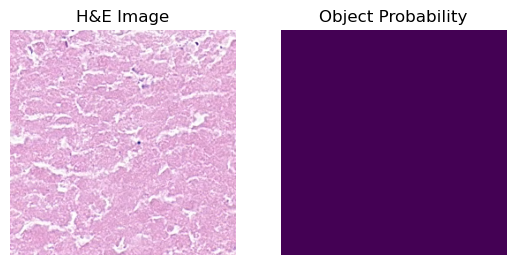

In [41]:
test_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=1)
data = next(iter(test_loader))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('H&E Image')  
plt.imshow(data[0][0].permute(1,2,0))
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Object Probability') 
plt.imshow(data[1][0])
plt.show()


In [42]:
image, obj_prob, star_distances, star_angles = data

## visualize "star points" from data loader

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

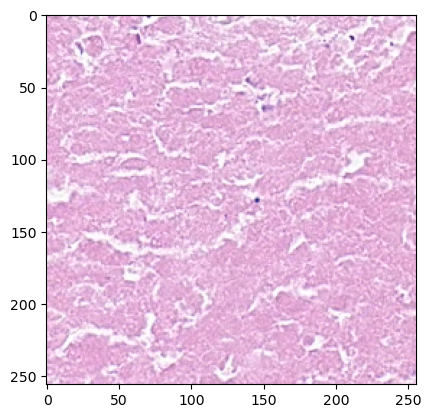

In [43]:
visualize(image[0], obj_prob[0], star_distances[0], star_angles[0])

In [ ]:
print(star_distances[0].shape)
print(star_angles[0].shape)

torch.Size([256, 256, 16])
torch.Size([256, 256, 16])


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = PretrainedUNet().to(device)
model1 = output_maps(n_rays=n_rays).to(device)

c:\Users\nisch\.conda\envs\cv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nisch\.conda\envs\cv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#Hyperparameters taken from paper:
batch_size = config['batch_size']
lr = config['lr']
num_epochs = config['num_epochs']
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss1 = torch.nn.BCEWithLogitsLoss()
loss2 = torch.nn.MSELoss(reduction='none')
loss3 = CircularAELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.5, patience=3, verbose=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=6)

In [ ]:
# cuda clear cache
torch.cuda.empty_cache()


## Training loop

In [ ]:
# save training loss
obj_prob_loss_epoch_train = []
dist_loss_epoch_train = []
angles_loss_epoch_train = []
total_loss_epoch_train = []
# save validation loss  
obj_prob_loss_epoch_val = []
dist_loss_epoch_val = []
angles_loss_epoch_val = []
total_loss_epoch_val = []
num_batches_train = len(train_loader)
num_batches_val = len(val_loader) 
# training loop 
for epoch in (range(num_epochs)):
    print("Epoch: {}".format(epoch))
    obj_prob_running_loss = 0.0
    dist_running_loss = 0.0
    angles_running_loss = 0.0
    total_running_loss = 0.0
    print("Train")
    model.train()
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        images, object_probabilities, star_poly_dist, star_angles = data
        images, object_probabilities, star_poly_dist, star_angles = images.to(device), object_probabilities.to(device), star_poly_dist.to(device), star_angles.to(device)
        # pdb.set_trace()
        outputs = model(images)
        pred_prob, pred_dist, pred_angles = model1(outputs)
        obj_prob_loss = loss1(pred_prob.squeeze(1), object_probabilities)
        dist_loss = torch.mean(loss2(pred_dist, star_poly_dist.permute(0,3,1,2)) * object_probabilities.unsqueeze(1))
        angles_loss = torch.mean(loss3(pred_angles, star_angles.permute(0,3,1,2)) * object_probabilities.unsqueeze(1))
        loss = obj_prob_loss + dist_loss + angles_loss
        # pdb.set_trace()
        loss.backward()
        optimizer.step()
        obj_prob_running_loss += obj_prob_loss.item()
        dist_running_loss += dist_loss.item()
        angles_running_loss += angles_loss.item()
        total_running_loss += loss.item()
    obj_prob_loss_epoch_train.append(obj_prob_running_loss/num_batches_train)
    dist_loss_epoch_train.append(dist_running_loss/num_batches_train)
    angles_loss_epoch_train.append(angles_running_loss/num_batches_train)
    total_loss_epoch_train.append(total_running_loss/num_batches_train)
    print("Object Probability Loss: {}, Distance Loss: {}, Angle loss: {}, Total loss: {}".format(obj_prob_loss_epoch_train[-1], dist_loss_epoch_train[-1], angles_loss_epoch_train[-1],total_loss_epoch_train[-1]))


    model.eval()
    with torch.no_grad():
        obj_prob_running_loss = 0.0
        dist_running_loss = 0.0
        angles_running_loss = 0.0
        total_running_loss = 0.0
        print("Validation")
        for i, data in enumerate(val_loader):
            images, object_probabilities, star_poly_dist, star_angles = data
            images, object_probabilities, star_poly_dist, star_angles = images.to(device), object_probabilities.to(device), star_poly_dist.to(device), star_angles.to(device)
            outputs = model(images)
            pred_prob, pred_dist,pred_angles = model1(outputs)
            obj_prob_loss = loss1(pred_prob.squeeze(1), object_probabilities)
            dist_loss = torch.mean(loss2(pred_dist, star_poly_dist.permute(0,3,1,2)) * object_probabilities.unsqueeze(1))
            angles_loss = torch.mean(loss3(pred_angles, star_angles.permute(0,3,1,2)) * object_probabilities.unsqueeze(1))
            loss = obj_prob_loss + dist_loss + angles_loss
            obj_prob_running_loss += obj_prob_loss.item()
            dist_running_loss += dist_loss.item()
            angles_running_loss += angles_loss.item()
            total_running_loss += loss.item()
        obj_prob_loss_epoch_val.append(obj_prob_running_loss/num_batches_val)
        dist_loss_epoch_val.append(dist_running_loss/num_batches_val)
        angles_loss_epoch_val.append(angles_running_loss/num_batches_val)
        total_loss_epoch_val.append(total_running_loss/num_batches_val)
        scheduler.step(total_loss_epoch_val[-1])
        print("Object Probability Loss: {}, Distance Loss: {}, Angle loss: {}, Total loss: {}".format(obj_prob_loss_epoch_val[-1], dist_loss_epoch_val[-1], angles_loss_epoch_val[-1],total_loss_epoch_val[-1]))
        # save model if best validation loss
        if total_loss_epoch_val[-1] == min(total_loss_epoch_val):
            torch.save(model.state_dict(), './output/weights/unet.pth')
            torch.save(model1.state_dict(), './output/weights/output_maps.pth')
            print("Saved model")


Epoch: 0
Train


120it [03:54,  1.95s/it]


Object Probability Loss: 0.19536450716356438, Distance Loss: 0.6637251685063045, Angle loss: 0.00426433133543469, Total loss: 0.8633540042986473
Validation
Object Probability Loss: 0.0866167739033699, Distance Loss: 0.2810443455974261, Angle loss: 0.0034688870810593167, Total loss: 0.3711300060153008
Saved model
Epoch: 1
Train


120it [03:58,  1.99s/it]


Object Probability Loss: 0.084372330053399, Distance Loss: 0.2504763547331095, Angle loss: 0.0031394393765367566, Total loss: 0.3379881225526333
Validation
Object Probability Loss: 0.079407483090957, Distance Loss: 0.2796796624859174, Angle loss: 0.0029780845390632747, Total loss: 0.36206522981325784
Saved model
Epoch: 2
Train


120it [03:58,  1.99s/it]


Object Probability Loss: 0.07020920437450211, Distance Loss: 0.24242540306101243, Angle loss: 0.0030786137969698755, Total loss: 0.31571321996549767
Validation
Object Probability Loss: 0.06644437822202841, Distance Loss: 0.2799214283625285, Angle loss: 0.003048014446782569, Total loss: 0.34941382308801017
Saved model
Epoch: 3
Train


120it [03:46,  1.88s/it]


Object Probability Loss: 0.06513186786323785, Distance Loss: 0.2190641904870669, Angle loss: 0.003392363824726393, Total loss: 0.2875884223729372
Validation
Object Probability Loss: 0.061913622294863066, Distance Loss: 0.23536947295069693, Angle loss: 0.0033544693995888036, Total loss: 0.30063755959272387
Saved model
Epoch: 4
Train


120it [03:46,  1.89s/it]


Object Probability Loss: 0.06219999557361007, Distance Loss: 0.19358817022293806, Angle loss: 0.003405354463029653, Total loss: 0.25919352074464164
Validation
Object Probability Loss: 0.05999747514724731, Distance Loss: 0.23082906330625216, Angle loss: 0.003376553285246094, Total loss: 0.29420309215784074
Saved model


## Inference

In [49]:
test_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=1)
model.load_state_dict(torch.load('./output/weights/unet.pth'))
model1.load_state_dict(torch.load('./output/weights/output_maps.pth'))

<All keys matched successfully>

In [50]:
model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, object_probabilities, star_poly_dist, star_angles = data
        images, object_probabilities, star_poly_dist, star_angles = images.to(device), object_probabilities.to(device), star_poly_dist.to(device), star_angles.to(device)
        outputs = model(images)
        pred_prob, pred_dist, pred_angles = model1(outputs)
        pred_prob = torch.sigmoid(pred_prob)
        break

In [65]:
final_masks = generate_masks(pred_prob.cpu(), pred_dist.cpu(), pred_angles.cpu())

In [66]:
instance_map = visualize_masks(final_masks)

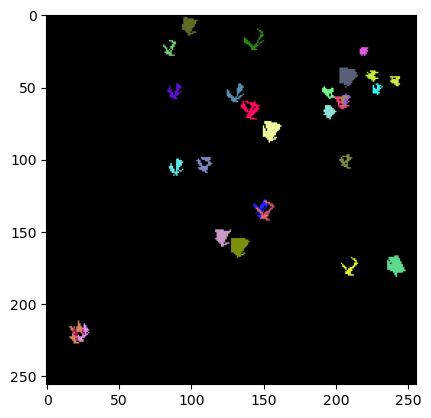

In [67]:
plt.imshow(instance_map)

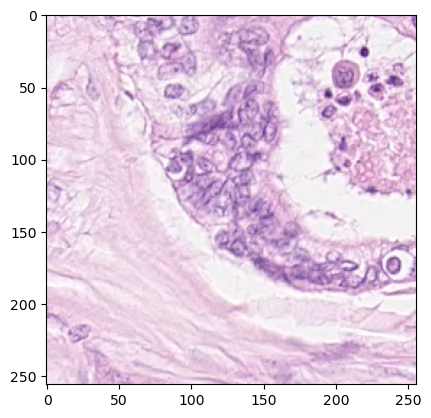

In [64]:
plt.imshow(images[0].permute(1,2,0).cpu().numpy())

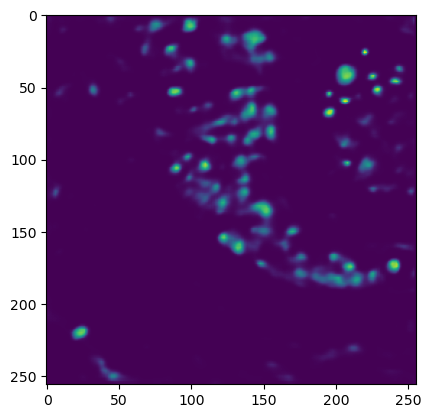

In [68]:
plt.imshow(pred_prob[0].cpu().numpy().squeeze(0))

In [70]:
pred_prob1 = pred_prob[0].cpu().numpy().squeeze()

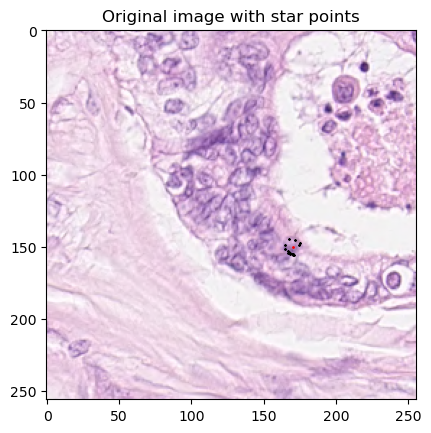

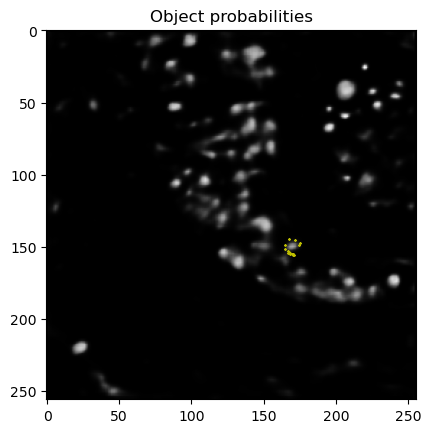

In [71]:
visualize(images[0].cpu(), pred_prob1, pred_dist[0].cpu().permute(1,2,0), pred_angles[0].cpu().permute(1,2,0))